# 基于KNO求解一维Burgers

[![下载Notebook](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.5.0/resource/_static/logo_notebook.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/r2.5.0/mindflow/zh_cn/data_driven/mindspore_burgers_KNO1D.ipynb)&emsp;[![下载样例代码](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.5.0/resource/_static/logo_download_code.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/r2.5.0/mindflow/zh_cn/data_driven/mindspore_burgers_KNO1D.py)&emsp;[![查看源文件](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.5.0/resource/_static/logo_source.svg)](https://gitee.com/mindspore/docs/blob/r2.5.0/docs/mindflow/docs/source_zh_cn/data_driven/burgers_KNO1D.ipynb)

## 概述

计算流体力学是21世纪流体力学领域的重要技术之一，其通过使用数值方法在计算机中对流体力学的控制方程进行求解，从而实现流动的分析、预测和控制。传统的有限元法（finite element method，FEM）和有限差分法（finite difference method，FDM）常用于复杂的仿真流程（物理建模、网格划分、数值离散、迭代求解等）和较高的计算成本，往往效率低下。因此，借助AI提升流体仿真效率是十分必要的。

近年来，随着神经网络的迅猛发展，为科学计算提供了新的范式。经典的神经网络是在有限维度的空间进行映射，只能学习与特定离散化相关的解。与经典神经网络不同，傅里叶神经算子（Fourier Neural Operator，FNO）是一种能够学习无限维函数空间映射的新型深度学习架构。该架构可直接学习从任意函数参数到解的映射，用于解决一类偏微分方程的求解问题，具有更强的泛化能力。更多信息可参考[Fourier Neural Operator for Parametric Partial Differential Equations](https://arxiv.org/abs/2010.08895)。

但是这类神经算子在学习非线性PDE的长期行为时，变得不够准确和缺乏可解释性。库普曼神经算子（Koopman neural operator，KNO）通过构建方程解的非线性动力学系统，克服了这一问题。通过近似Koopman算子，一个控制动力学系统所有可能观测的无限维线性算子，作用于动力学系统的流映射，我们可以通过求解简单的线性预测问题等价地学习整个非线性PDE族的解。更多信息可参考：

- "[Koopman neural operator as a mesh-free solver of non-linear partial differential equations](https://arxiv.org/abs/2301.10022)." arXiv preprint arXiv:2301.10022 (2023).
- "[KoopmanLab: machine learning for solving complex physics equations](https://arxiv.org/abs/2301.01104)." arXiv preprint arXiv:2301.01104 (2023).

本案例教程介绍利用库普曼神经算子的1-d Burgers方程求解方法。

## 伯格斯方程（Burgers' equation）

一维伯格斯方程（1-d Burgers' equation）是一个非线性偏微分方程，具有广泛应用，包括一维粘性流体流动建模。它的形式如下：

$$
\partial_t u(x, t)+\partial_x (u^2(x, t)/2)=\nu \partial_{xx} u(x, t), \quad x \in(0,1), t \in(0, 1]
$$

$$
u(x, 0)=u_0(x), \quad x \in(0,1)
$$

其中$u$表示速度场，$u_0$表示初始条件，$\nu$表示粘度系数。

## 问题描述

本案例利用Koopman Neural Operator学习初始状态到下一时刻状态的映射，实现一维Burgers'方程的求解：

$$
u_0 \mapsto u(\cdot, 1)
$$

## 技术路径

MindSpore Flow求解该问题的具体流程如下：

1. 创建数据集。
2. 构建模型。
3. 优化器与损失函数。
4. 模型训练。
5. 模型推理和可视化。

## Koopman Neural Operator

Koopman Neural Operator模型构架如下图所示，包含上下两个主要分支和对应输出。图中Input表示初始涡度，上路分支通过Encoding Layer实现输入向量的高维映射，然后将映射结果作为Koopman Layer的输入，进行频域信息的非线性变换，最后由Decoding Layer将变换结果映射至最终的预测结果Prediction。同时，下路分支通过Encoding Layer实现输入向量的高维映射，然后通过Decoding Layer对输入进行重建。上下两个分支的Encoding Layer之间共享权重，Decoding Layer之间也共享权重。Prediction用于和Label计算预测误差，Reconstruction用于和Input计算重建误差。两个误差共同指导模型的梯度计算。

Encoding Layer、Koopman Layer、Decoding Layer以及两分支共同组成了Koopman Neural Operator。

Koopman Layer结构如虚线框所示，可重复堆叠。向量经过傅里叶变换后，再经过线性变换，过滤高频信息，然后进行傅里叶逆变换；输出结果与输入相加，最后通过激活函数，得到输出向量。

![Fourier Layer网络结构](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.5.0/docs/mindflow/docs/source_zh_cn/data_driven/images/kno.jpg)

In [9]:
import os
import time
import datetime
import numpy as np

import mindspore
from mindspore import nn, context, ops, Tensor, set_seed
from mindspore.nn import MSELoss

from mindflow.cell import KNO1D
from mindflow.common import get_warmup_cosine_annealing_lr
from mindflow.utils import load_yaml_config

下述`src`包可以在[applications/data_driven/burgers/kno1d/src](https://gitee.com/mindspore/mindscience/tree/r0.7/MindFlow/applications/data_driven/burgers/kno1d/src)下载。

In [10]:
from src.dataset import create_training_dataset
from src.trainer import BurgersWithLoss
from src.utils import visual

set_seed(0)
np.random.seed(0)

print("pid:", os.getpid())
print(datetime.datetime.now())

context.set_context(mode=context.GRAPH_MODE, device_target='Ascend', device_id=1)
use_ascend = context.get_context(attr_key='device_target') == "Ascend"

pid: 9647
2023-03-04 08:03:20.885806


从[config](https://gitee.com/mindspore/mindscience/blob/r0.7/MindFlow/applications/data_driven/burgers/kno1d/configs/kno1d.yaml)中获得模型、数据、优化器的超参。

In [11]:
config = load_yaml_config('kno1d.yaml')
data_params = config["data"]
model_params = config["model"]
optimizer_params = config["optimizer"]

## 创建数据集

下载训练与测试数据集: [data_driven/burgers/dataset](https://download.mindspore.cn/mindscience/mindflow/dataset/applications/data_driven/burgers/dataset/)。

本案例根据Zongyi Li在 [Fourier Neural Operator for Parametric Partial Differential Equations](https://arxiv.org/pdf/2010.08895.pdf) 一文中对数据集的设置生成训练数据集与测试数据集。具体设置如下：
基于周期性边界，生成满足如下分布的初始条件$u_0(x)$：

$$
u_0 \sim \mu, \mu=\mathcal{N}\left(0,625(-\Delta+25 I)^{-2}\right)
$$

本案例选取粘度系数$\nu=0.1$，并使用分步法求解方程，其中热方程部分在傅里叶空间中精确求解，然后使用前向欧拉方法求解非线性部分。训练集样本量为1000个，测试集样本量为200个。

In [12]:
# create training dataset
train_dataset = create_training_dataset(data_params, shuffle=True)

# create test dataset
eval_dataset = create_training_dataset(
    data_params, shuffle=False, is_train=False)

Data preparation finished
input_path:  (1000, 1024, 1)
label_path:  (1000, 1024)
Data preparation finished
input_path:  (200, 1024, 1)
label_path:  (200, 1024)


## 构建模型

网络由1层共享的Encoding Layer、多层Koopman Layer以及1层共享的Decoding Layer叠加组成：

- Encoding Layer对应样例代码中`KNO1D.enc`，将输出数据映射至高维；
- Koopman Layer对应样例代码中`KNO1D.koopman_layer`，本案例采用离散傅里叶变换实现时域与频域的转换；
- Decoding Layer对应代码中`KNO1D.dec`，获得最终的预测值。

基于上述网络结构，进行模型初始化，其中模型超参可在配置文件中修改。

In [13]:
model = KNO1D(in_channels=data_params['in_channels'],
              channels=model_params['channels'],
              modes=model_params['modes'],
              depths=model_params['depths'],
              resolution=model_params['resolution']
              )

model_params_list = []
for k, v in model_params.items():
    model_params_list.append(f"{k}:{v}")
model_name = "_".join(model_params_list)
print(model_name)

name:KNO1D_channels:32_modes:64_depths:4_resolution:1024


## 优化器与损失函数

使用均方误差作为训练的损失函数：

In [14]:
train_size = train_dataset.get_dataset_size()
eval_size = eval_dataset.get_dataset_size()

lr = get_warmup_cosine_annealing_lr(lr_init=optimizer_params["lr"],
                                    last_epoch=optimizer_params["epochs"],
                                    steps_per_epoch=train_size,
                                    warmup_epochs=1)
optimizer = nn.AdamWeightDecay(model.trainable_params(),
                               learning_rate=Tensor(lr),
                               weight_decay=optimizer_params["weight_decay"])
model.set_train()
loss_fn = MSELoss()
if use_ascend:
    from mindspore.amp import DynamicLossScaler, auto_mixed_precision, all_finite
    loss_scaler = DynamicLossScaler(1024, 2, 100)
    auto_mixed_precision(model, 'O3')
else:
    loss_scaler = None

## 模型训练

使用**MindSpore>= 2.0.0**的版本，可以使用函数式编程范式训练神经网络。

In [15]:
problem = BurgersWithLoss(model, data_params["out_channels"], loss_fn)

def forward_fn(inputs, labels):
    loss, l_recons, l_pred = problem.get_loss(inputs, labels)
    if use_ascend:
        loss = loss_scaler.scale(loss)
    return loss, l_recons, l_pred

grad_fn = ops.value_and_grad(forward_fn, None, optimizer.parameters, has_aux=True)

def train_step(inputs, labels):
    (loss, l_recons, l_pred), grads = grad_fn(inputs, labels)
    if use_ascend:
        loss = loss_scaler.unscale(loss)
        if all_finite(grads):
            grads = loss_scaler.unscale(grads)
    loss = ops.depend(loss, optimizer(grads))
    return loss, l_recons, l_pred

def eval_step(inputs, labels):
    return problem.get_rel_loss(inputs, labels)

train_sink = mindspore.data_sink(train_step, train_dataset, sink_size=1)
eval_sink = mindspore.data_sink(eval_step, eval_dataset, sink_size=1)

summary_dir = os.path.join(config["summary_dir"], model_name)
os.makedirs(summary_dir, exist_ok=True)
print(summary_dir)

for epoch in range(1, optimizer_params["epochs"] + 1):
    time_beg = time.time()
    l_recons_train = 0.0
    l_pred_train = 0.0
    for _ in range(train_size):
        _, l_recons, l_pred = train_sink()
        l_recons_train += l_recons.asnumpy()
        l_pred_train += l_pred.asnumpy()
    l_recons_train = l_recons_train / train_size
    l_pred_train = l_pred_train / train_size
    print(f"epoch: {epoch}, time cost: {(time.time() - time_beg):>8f},"
          f" recons loss: {l_recons_train:>8f}, pred loss: {l_pred_train:>8f}")

    if epoch % config['eval_interval'] == 0:
        l_recons_eval = 0.0
        l_pred_eval = 0.0
        print("---------------------------start evaluation-------------------------")
        for _ in range(eval_size):
            l_recons, l_pred = eval_sink()
            l_recons_eval += l_recons.asnumpy()
            l_pred_eval += l_pred.asnumpy()
        l_recons_eval = l_recons_eval / eval_size
        l_pred_eval = l_pred_eval / eval_size
        print(f'Eval epoch: {epoch}, recons loss: {l_recons_eval},'
              f' relative pred loss: {l_pred_eval}')
        print("---------------------------end evaluation---------------------------")
        mindspore.save_checkpoint(model, ckpt_file_name=summary_dir + '/save_model.ckpt')

./summary_dir/name:KNO1D_channels:32_modes:64_depths:4_resolution:1024


epoch: 1, time cost: 18.375901, recons loss: 0.295517, pred loss: 0.085093
epoch: 2, time cost: 2.577698, recons loss: 0.161718, pred loss: 0.002227
epoch: 3, time cost: 2.564470, recons loss: 0.027144, pred loss: 0.000992
epoch: 4, time cost: 2.547690, recons loss: 0.000782, pred loss: 0.000511
epoch: 5, time cost: 2.532924, recons loss: 0.000057, pred loss: 0.000279
epoch: 6, time cost: 2.536904, recons loss: 0.000048, pred loss: 0.000241
epoch: 7, time cost: 2.527330, recons loss: 0.000048, pred loss: 0.000213
epoch: 8, time cost: 2.536032, recons loss: 0.000048, pred loss: 0.000227
epoch: 9, time cost: 2.462490, recons loss: 0.000048, pred loss: 0.000230
epoch: 10, time cost: 2.564090, recons loss: 0.000049, pred loss: 0.000229
---------------------------start evaluation-------------------------
Eval epoch: 10, recons loss: 4.7733558130858e-05, relative pred loss: 0.01156728882342577
---------------------------end evaluation---------------------------

...

epoch: 91, time cost: 2.

## 模型推理和可视化

取6个样本做连续10步预测，并可视化。

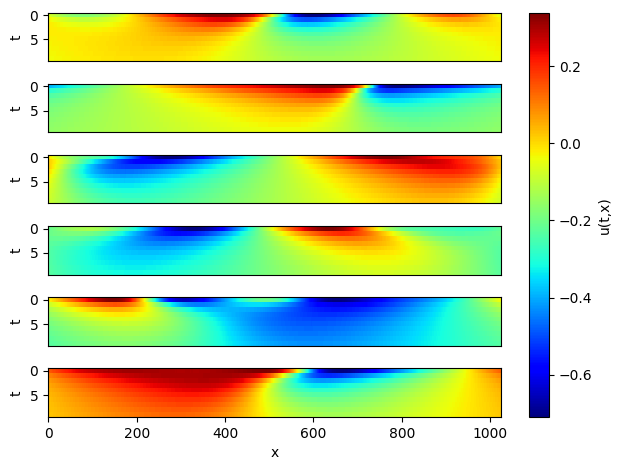

In [16]:
# Infer and plot some data.
inputs = np.load(os.path.join(data_params["path"], "test/inputs.npy"))  # (200,1024,1)
problem = BurgersWithLoss(model, 10, loss_fn)
visual(problem, inputs)